In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from CoExBO._utils import TensorManager
from botorch.models import SingleTaskGP
from botorch import fit_gpytorch_mll
from botorch.optim.fit import fit_gpytorch_mll_torch
from gpytorch import ExactMarginalLogLikelihood
tm = TensorManager()
warnings.filterwarnings('ignore')

n_dims = 6                    # number of dimensions
dataset = "ranger"
seed = 1            # random seed for reproduce the results #SEED 8 rpart_preproc, SEED 3 for Ranger, SEED 1 for rpart (50000_ckpt), 5 for rpart val, 

/home/lunari/hnap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
class Benchmark():
    def __init__(self, X_data, Y_data, sample = False):
        # self.X_data = X_data
        # self.Y_data = Y_data
        if sample:
            self.X_data, self.Y_data = self.sample_for_training(X_data, Y_data)
        else:
            self.X_data, self.Y_data = X_data, Y_data
        print("Training Model")
        self.gp_model = SingleTaskGP(torch.tensor(self.X_data), torch.tensor(self.Y_data))
        mll = ExactMarginalLogLikelihood(self.gp_model.likelihood, self.gp_model)
        fit_gpytorch_mll(mll=mll)
        print("Training Done")

    def find_closest_point(self, query, loop = False):
        y_set = []
        query = query.squeeze()
        self.gp_model.eval()
        if len(query.shape) > 1:
            for X in query:
                posterior = self.gp_model.posterior(X.unsqueeze(0).float())
                mean = posterior.mean.item()
                variance = posterior.variance.item()

                # distances = np.linalg.norm(self.X_data - X, axis=1)
                # closest_index = np.argmin(distances)
                # y = self.Y_data[closest_index]
                mean = np.clip(mean,0,1)
                y_set.append(mean)
            return torch.tensor(y_set, dtype=torch.float32).squeeze()
        else:
            X = query#.detach().numpy()
            posterior = self.gp_model.posterior(X.unsqueeze(0).float().cpu())
            mean = posterior.mean.item()
            variance = posterior.variance.item()
            mean = np.clip(mean,0,1)
            return torch.tensor(mean, dtype=torch.float32).reshape([1])

    def sample_for_training(self, X, Y):
        Y = Y.squeeze()
        yuniq, ycount = np.unique(Y, return_counts=True)
        # print(yuniq)
        # print(ycount)
        counts = {v: c for v, c in zip(yuniq, ycount)}

        # print(counts)
        # for i in range(len(Y)):
        #     print(Y[i])
        #     print(counts[Y[i]])
        logits = np.array([Y[i] / counts[Y[i]] for i in range(len(Y))])
        freq_idx = logits.argsort()[::-1]

        selected_rows = freq_idx[:(3 * len(yuniq))]
        np.random.shuffle(selected_rows)
        X = X[selected_rows]
        Y = Y[selected_rows]
        #stdY = (Y - Y.mean()) / Y.std()

        num_dims = list(np.arange(X.shape[-1]))
        cat_dims = []

        # Fit and save GP
        print(f'Fit GP on dataset {dataset} containing {X.shape[0]} points...')
        X_ = torch.from_numpy(X).to(dtype=torch.float64)
        Y_ = torch.from_numpy(Y).to(dtype=torch.float64)
        #print("Y SHAPE: ", Y.shape)
        return X_, Y_.unsqueeze(1)
    
    def clean(self):
        del self.gp_model
        torch.cuda.empty_cache()


In [3]:
lower_limit = 0
upper_limit = 1
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

In [4]:
import seaborn as sns
import pandas as pd

# set bounds

mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)

# visualise domain
samples = domain.sample(1000)
# sns.pairplot(pd.DataFrame(tm.numpy(samples)))
#plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [5]:
from CoExBO._coexbo import CoExBOwithSimulation, StateManager, CoExBO
n_init_pref = 1      # number of initial random samples for preferential learning
n_init_obj = 1        # number of initial random samples for objective function

In [6]:
from importlib.machinery import SourceFileLoader
def load_module(filename):
    module_name = os.path.splitext(os.path.basename(filename))[0]
    return SourceFileLoader(module_name, filename).load_module(module_name)
import yaml
model_type = 'tnpa'
model_cls = getattr(load_module(f'./models/{model_type}.py'), model_type.upper())
with open(f'configs/{dataset}/{model_type}.yaml', 'r') as f:
    config = yaml.safe_load(f)
#if args.model in ["np", "anp", "cnp", "canp", "bnp", "banp", "tnpa", "tnpd", "tnpnd"]:
model = model_cls(**config)
model.cuda()
import os.path as osp
import torch
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.utils import t_batch_mode_transform
from CoExBO._utils import TensorManager

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results_path = './results/'
model_name = 'tnpa'
ckpt_path = osp.join(results_path, dataset, model_name, '760000_ckpt.tar')

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt.model)

def sample_from_training(X_train, y_train, max_points = 100):
    samples_X = []
    samples_y = []
    for i in range(len(X_train)):
        if len(X_train[i]) < max_points:
            points_to_sample = len(X_train[i])
        else:
            points_to_sample = max_points
        r_idx = np.random.randint(0,len(X_train[i]),points_to_sample)
        samples_X.append(X_train[i][r_idx])
        samples_y.append(y_train[i][r_idx])
    return samples_X, samples_y

## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [7]:
n_iterations = 50     # number of iterations


# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims, beta_init = 0.5)

torch.Size([20, 6])
TEST TASK:  0
Training Model


Training Done
X0 (preference): tensor([0.9337, 0.8020, 0.6820, 0.9400, 0.4358, 0.2899], device='cuda:0')
X1 (normal UCB): tensor([0.4489, 0.8821, 0.8542, 0.1960, 0.2023, 0.9920], device='cuda:0')
You chose X0
0) parameters: beta 4.243e+00 gamma 0.000e+00
dataset_obj:  tensor([0.1787])
training models...
generating candidates...
X0 (preference): tensor([0.9620, 0.0000, 0.9031, 0.4891, 0.0000, 1.0000])
X1 (normal UCB): tensor([0.9508, 0.0000, 0.3010, 0.9198, 1.0000, 0.0000])
Do you need more explanation on the two candidates?


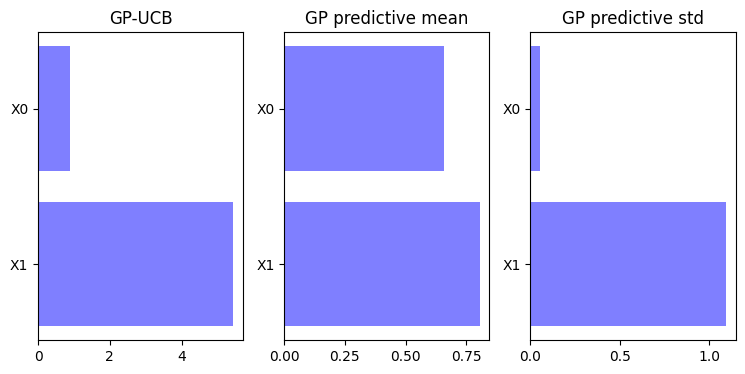

Do you want to know the attribution to each feature?
YES SHAPLEY
X_suggest
feature_names:  ['SUM', 'ft0', 'ft1', 'ft2', 'ft3', 'ft4', 'ft5']


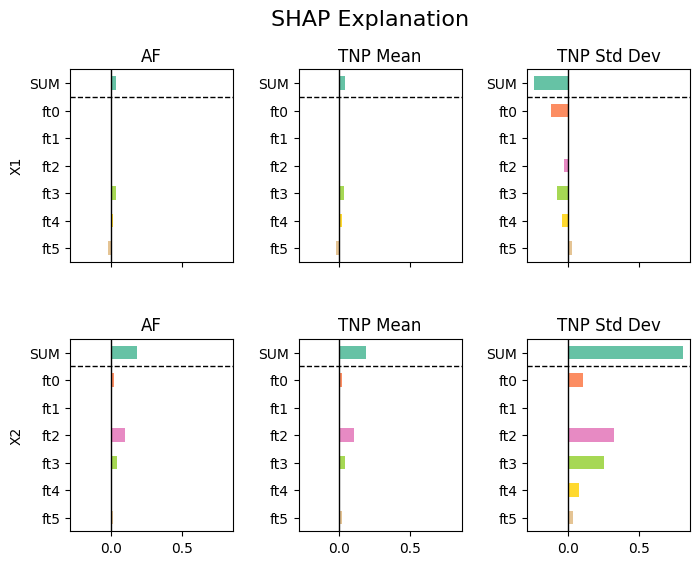

Do you want to visualise the GP on the plane where two candidates are placed?
dims:  [0,1]
best observed, white dot o:tensor([0.9944, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000])
X0 (preference), black star *:tensor([0.9620, 0.0000, 0.9031, 0.4891, 0.0000, 1.0000])
X1 (normal UCB), green cross +:tensor([0.9508, 0.0000, 0.3010, 0.9198, 1.0000, 0.0000])
observed points, yellow cross x


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

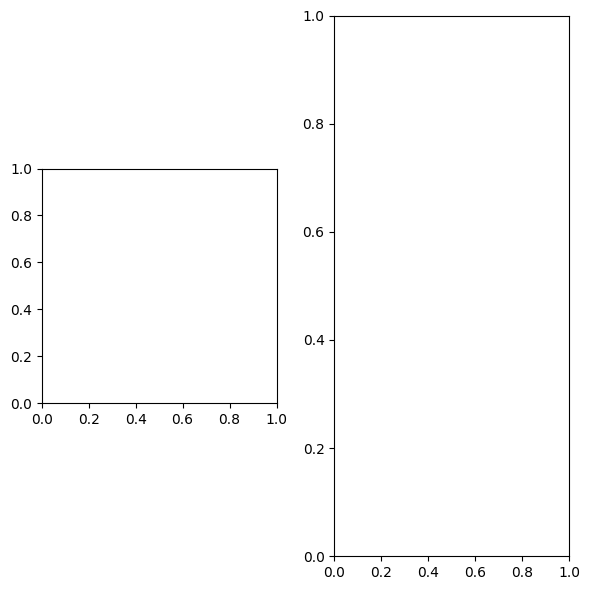

In [8]:
results = []
import numpy as np
meta = True
X_test = np.load(f'./datasets/{dataset}/X_test.npz')
y_test = np.load(f'./datasets/{dataset}/y_test.npz')
X_validation = np.load(f'./datasets/{dataset}/X_validation.npz')
y_validation = np.load(f'./datasets/{dataset}/y_validation.npz')

X_test_ = np.array([X_test[key].astype('float32') for key in X_test.keys()])
y_test_ = np.array([y_test[key].astype('float32') for key in y_test.keys()])


X_validation_ = np.array([X_validation[key].astype('float32') for key in X_validation.keys()])
y_validation_ = np.array([y_validation[key].astype('float32') for key in y_validation.keys()])

samples_val_X, samples_val_y = sample_from_training(X_validation_, y_validation_, max_points=10)


samples_val_X = torch.tensor(np.vstack(samples_val_X))
samples_val_y = torch.tensor(np.vstack(samples_val_y))

print(samples_val_X.shape)
best_values = []
total_trajectories = []
max_num_points = 1000
best_values = []
total_trajectories = []
samplig = False
exploration_rate = 0.5
for i in range(len(X_test)):
    print("TEST TASK: ", i)
    benchmark = Benchmark(X_test_[i], y_test_[i], sample=samplig)

    true_function = benchmark.find_closest_point
    if len(X_test_[i]) > max_num_points:
        r_idx = np.random.randint(0,len(X_test_[i]),max_num_points)
        model.test_set_X = X_test_[i][r_idx]
    else:
        model.test_set_X = X_test_[i]
    model.w_exploration = exploration_rate
    model.samples_x = samples_val_X
    min_test_idx = np.argmin(y_test_[i])

    x_val = torch.tensor(X_test_[i][min_test_idx]).unsqueeze(0)
    y_val = true_function(x_val)
    dataset_obj = (x_val,y_val)
    

    coexbo = CoExBO(domain, true_function, hallucinate=False, meta = meta)

    _, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

    max_bv = -1
    trajectory = [y_val]
    Y_0_values = []
    Y_1_values = []
    for t in range(n_iterations):
        beta, gamma = state(t)
        print("dataset_obj: ", dataset_obj[1])
        result, dataset_obj, dataset_duel, Y_returns = coexbo(
            dataset_obj, dataset_duel, beta, gamma, model_TPN = model, lower_limit= lower_limit, upper_limit=upper_limit
        )
        best_v = dataset_obj[1].max().item()
        if best_v > max_bv:
            max_bv = best_v
        trajectory.append(max_bv)

        results.append(result)


    total_trajectories.append(dataset_obj[1].detach().cpu().numpy())
    #best_values.append(trajectory)
    #benchmark2.clean()
    benchmark.clean()

results = torch.tensor(results)

In [ ]:
import pickle
# Save the object as a pickle file 
with open(f'evaluations/meta_{dataset}_hv1.pkl', 'wb') as file: #rpart v1 evaluated on ckpt 50000, best one so far
    pickle.dump(total_trajectories, file)

# Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [ ]:
best_values